# Project Overview: NLP Disaster Tweets Classification

## 1. Introduction
The goal of this project is to classify tweets into two categories:
- **1**: The tweet is about a real disaster.
- **0**: The tweet is not about a real disaster.

This project is based on the Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started).
It is a beginner-friendly competition designed to help participants practice text classification techniques in Natural Language Processing (NLP).

## 2. Dataset
The dataset consists of:
- **train.csv**: 7,613 labeled tweets (with `target` column as label).
- **test.csv**: 3,263 tweets without labels (to be predicted for Kaggle submission).
- **sample_submission.csv**: Template file for Kaggle submission format.

Columns in `train.csv`:
- `id`: Unique identifier for the tweet.
- `text`: The content of the tweet.
- `location`: Location from which the tweet was sent (may be missing).
- `keyword`: Specific keyword extracted from the tweet (may be missing).
- `target`: Binary label (1 = disaster-related, 0 = not disaster-related).

## 3. Project Steps
1. Data loading and inspection  
2. Exploratory Data Analysis (EDA) and preprocessing  
3. Feature extraction (TF-IDF, word embeddings, etc.)  
4. Model building and training  
5. Evaluation and hyperparameter tuning  
6. Submission to Kaggle

In [1]:
# Step 0: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os

# Machine learning related libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1: Brief Description of the Problem and Data

This competition focuses on binary text classification in the context of disaster-related tweets.
Given a short text (a tweet), the model needs to determine whether the tweet is about a real disaster or not.

**Why this step is important:**  
Before building any model, it is crucial to understand the data structure, column meanings, and data completeness.  
This step ensures that we are familiar with what each column represents and can identify potential challenges such as missing values or imbalanced data.

**Data Overview**:
- **Training set**: 7,613 tweets with labels (`target` column).
- **Test set**: 3,263 tweets without labels (predictions will be submitted to Kaggle for scoring).
- **Sample submission**: Template for final submission format.

The dataset has some missing values in `keyword` and `location`, but the `text` column is complete and will serve as the primary source of information for the model.

In [2]:
# Step 1: Set the data path (change this if your files are stored elsewhere)
data_path = r"D:/AI/CU-AI/Vicky/Class 3/W4"

# Step 2: Load datasets
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# Step 3: Display dataset shapes
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

# Step 4: Preview the training data
train_df.head()

Train set shape: (7613, 5)
Test set shape: (3263, 4)
Sample submission shape: (3263, 2)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Step 2: Exploratory Data Analysis (EDA) and Cleaning Variants

This step explores the dataset’s structure, missingness, and key patterns, followed by designing multiple text-cleaning variants for later modeling comparisons.

---

### 2.1 Missing Values
- **Observation:** `keyword` is missing in about one-third of the records, and `location` in more than half.
- **Implication:** While they may contain useful context, the high missing rates mean we cannot rely solely on these fields for predictions.
- **Decision:** `text` — which is complete — will serve as the primary feature for model training, with selective use of `keyword`/`location` where beneficial.

---

### 2.2 Tweet Length Distribution
- **Observation:** Disaster-related tweets (`target=1`) tend to have slightly higher character counts, likely due to inclusion of specific details (numbers, place names, event descriptions).
- **Implication:** Length alone is insufficient for classification, but can be used as a weak auxiliary feature.

---

### 2.3 Keyword Frequency
- **Observation:** Certain keywords (e.g., “fatalities”, “damage”, “deluge”) appear more often in disaster tweets.
- **Implication:** `keyword` presence can add signal when combined with text features.

---

### 2.4 Keyword Association with Disaster Tweets
We compute `P(target=1 | keyword)` to see which keywords are most/least indicative:
- **Top 15**: e.g., “oil spill”, “suicide bombing”, “nuclear disaster”, “rescuers”.
- **Bottom 15**: e.g., “aftershock”, “blazing”, “panic” (often appear in non-disaster contexts).
- **Implication:** These probabilities can serve as strong categorical priors in modeling.

---

### 2.5 Data Cleaning with Variants

**Objective:**  
Prepare multiple cleaned versions of the text so we can evaluate the impact of preprocessing decisions on downstream model performance.

**Rationale for Multiple Variants:**
- Preprocessing choices can significantly affect accuracy.
- Removing too much may lose valuable context; removing too little may retain noise.
- Instead of a “one-size-fits-all” pipeline, we design three variants for controlled comparison.

**Cleaning Variants:**
1. **Variant 1 — `clean_v1_numtoken_stoprm`**  
   - Numbers → `<NUM>` token.  
   - Stopwords removed to reduce noise from common words.  
   - Best suited if numeric details are less important, aiming for higher semantic clarity.
   
2. **Variant 2 — `clean_v2_numtoken_keepstp`**  
   - Numbers → `<NUM>` token.  
   - Stopwords kept to preserve sentence structure/context.  
   - Useful when syntactic relationships may help classification.
   
3. **Variant 3 — `clean_v3_nonum_stoprm`**  
   - Digits removed entirely.  
   - Stopwords removed.  
   - Acts as a middle ground to test whether removing numbers benefits topic separation.

---

### 2.6 EDA for Cleaning Variants

We compare the three cleaned columns (`clean_v1_numtoken_stoprm`, `clean_v2_numtoken_keepstp`, `clean_v3_nonum_stoprm`) in the training set.

**We show:**
1. **Token length KDE curves** — to quantify aggressiveness of each cleaning method.
2. **Side-by-side word clouds** — to visualize salient terms retained under each variant.
3. **Merged Top-20 token table** — with color highlights (e.g., red marks) for tokens present in one variant but not another.

**Interpretation Guide:**
- Left-shifted KDE curves → more aggressive cleaning (shorter average text length).
- `<NUM>` frequency → importance of numeric information in the corpus.
- Stopword removal → amplifies domain-specific vocabulary in visualizations.

**Baseline Decision:**  
We will use `clean_v1_numtoken_stoprm` as the initial baseline for TF-IDF + Logistic Regression, and compare with `clean_v2_numtoken_keepstp` in the results section to measure the effect of retaining stopwords.

Missing Values in Training Data:
          Missing Values  Percentage (%)
location            2533           33.27
keyword               61            0.80
id                     0            0.00
text                   0            0.00
target                 0            0.00


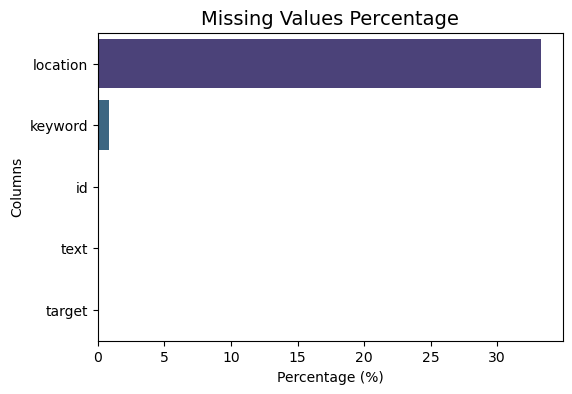

In [3]:
# 2.1. Missing values analysis
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(train_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
print("Missing Values in Training Data:")
print(missing_df)

# Plot missing values
plt.figure(figsize=(6,4))
sns.barplot(x=missing_percentage, y=missing_percentage.index, palette="viridis")
plt.title("Missing Values Percentage", fontsize=14)
plt.xlabel("Percentage (%)")
plt.ylabel("Columns")
plt.show()

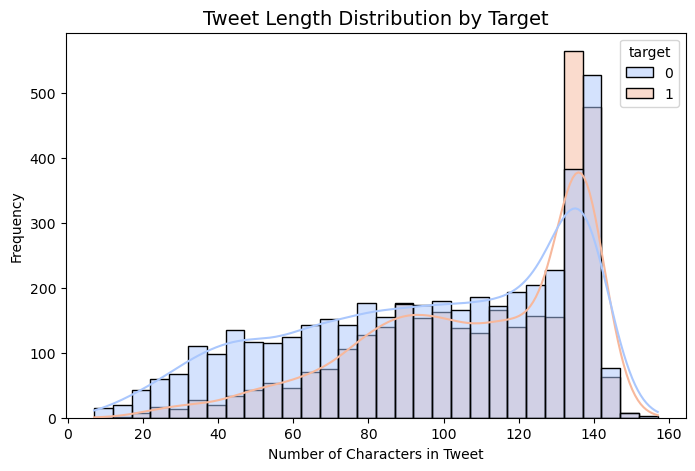

In [4]:
# 2.2. Tweet length distribution
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=train_df, x='text_length', hue='target', bins=30, kde=True, palette='coolwarm')
plt.title("Tweet Length Distribution by Target", fontsize=14)
plt.xlabel("Number of Characters in Tweet")
plt.ylabel("Frequency")
plt.show()

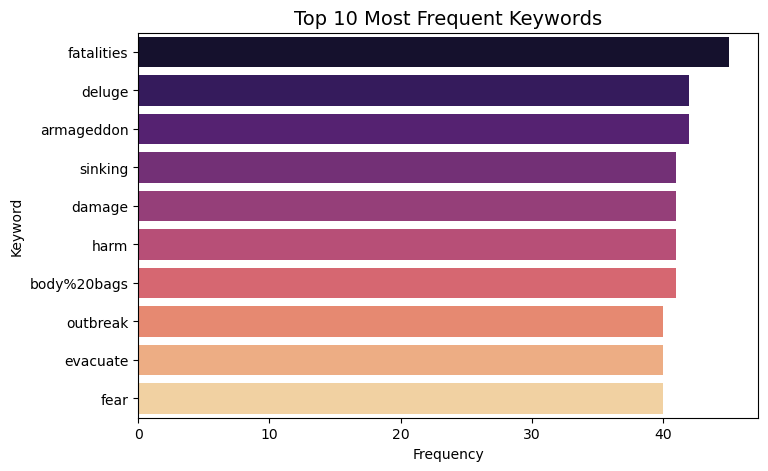

In [5]:
# 2.3. Keyword frequency (Top 10)

top_keywords = train_df['keyword'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="magma")
plt.title("Top 10 Most Frequent Keywords", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()

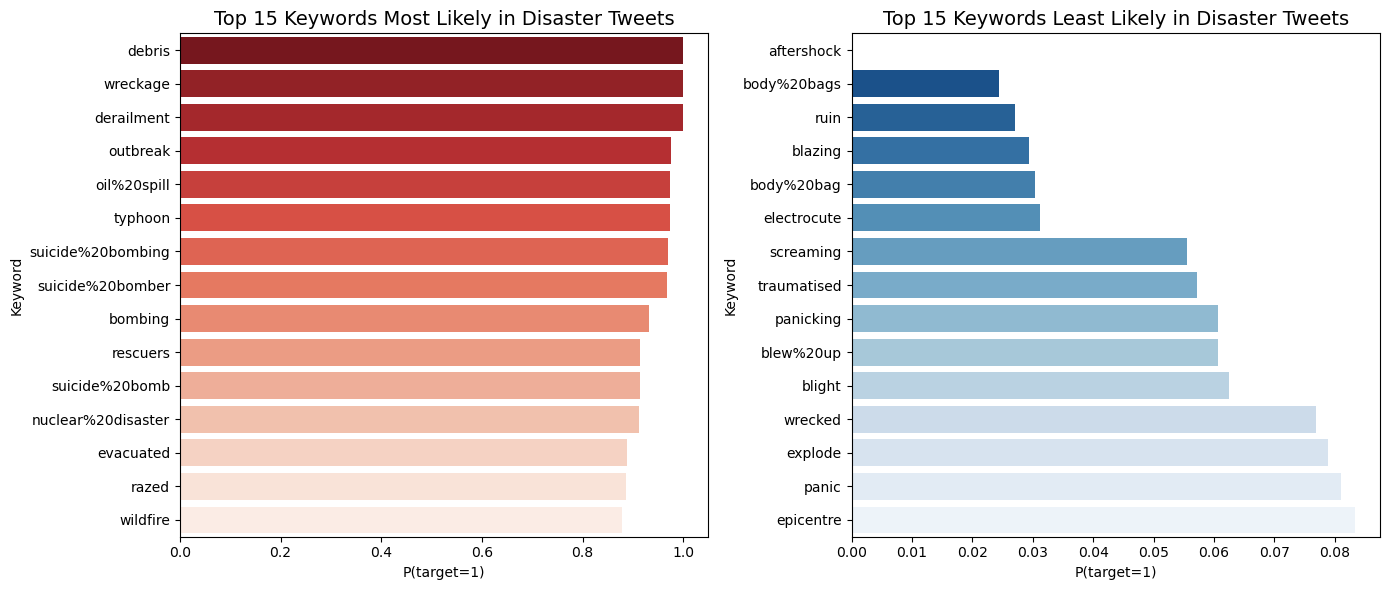

In [6]:
# 2.4.Calculate mean target probability for each keyword
keyword_target_mean = train_df.groupby('keyword')['target'].mean().reset_index()

# Top 15 most likely disaster keywords
top_keywords_disaster = keyword_target_mean.sort_values(by='target', ascending=False).head(15)

# Top 15 least likely disaster keywords
top_keywords_non_disaster = keyword_target_mean.sort_values(by='target', ascending=True).head(15)

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=False)

# Left plot: most likely disaster
sns.barplot(data=top_keywords_disaster, x='target', y='keyword', palette='Reds_r', ax=axes[0])
axes[0].set_title("Top 15 Keywords Most Likely in Disaster Tweets", fontsize=14)
axes[0].set_xlabel("P(target=1)")
axes[0].set_ylabel("Keyword")

# Right plot: least likely disaster
sns.barplot(data=top_keywords_non_disaster, x='target', y='keyword', palette='Blues_r', ax=axes[1])
axes[1].set_title("Top 15 Keywords Least Likely in Disaster Tweets", fontsize=14)
axes[1].set_xlabel("P(target=1)")
axes[1].set_ylabel("Keyword")

plt.tight_layout()
plt.show()


### EDA Insights and Reasoning

**1. Missing values:**  
The `keyword` column is missing in about one-third of the records, and the `location` column is missing in more than half.  
While these fields may contain useful context, their high missing rates mean we cannot rely solely on them for predictions.  
Therefore, the `text` column — which is complete — will be the primary feature for model training, with potential selective use of `keyword` and `location` through imputation or encoding.

**2. Tweet length distribution:**  
Disaster-related tweets (target=1) tend to have slightly higher character counts, likely due to the inclusion of specific details such as numbers, place names, or event descriptions.  
However, there is significant overlap between the two classes, indicating that length alone is insufficient for accurate classification, though it can serve as a supportive feature.

**3. Keyword frequency:**  
Certain keywords (e.g., "fatalities", "damage", "deluge") appear more often in disaster-related tweets, suggesting that keyword presence can provide valuable signals when combined with text-based features.

**4. Extra EDA – Keyword association with disaster tweets:**    
We computed the probability that a tweet is disaster-related given the keyword (`P(target=1 | keyword)`).  
The left chart shows the top 15 keywords with the highest probabilities (e.g., "oil spill", "suicide bombing", "nuclear disaster"), which almost always indicate a disaster.  
The right chart shows the top 15 keywords with the lowest probabilities (e.g., "aftershock", "blazing", "panic"), which are much more likely to appear in non-disaster contexts despite their potentially alarming wording.  
This side-by-side comparison highlights which keywords can serve as strong categorical predictors in the model.

## Step 2.5 — Data Cleaning with Variants

### Objective
The purpose of this step is to prepare multiple cleaned versions of the text data so that we can later evaluate the impact of different preprocessing decisions on model performance.  
By designing multiple cleaning strategies in parallel, we can test whether retaining certain information (e.g., numbers, stopwords) contributes to better topic extraction and classification accuracy.

### Rationale for Multiple Variants
- **Data preprocessing choices can significantly affect downstream model accuracy**.  
  Removing too much information might hurt performance, while leaving too much noise may also reduce accuracy.
- Instead of applying a single “one-size-fits-all” cleaning pipeline, we design *three* variants for a controlled comparison.
- This approach ensures our later topic modeling results are not biased by a single arbitrary cleaning decision.

### Cleaning Variants
1. **Variant 1: `clean_v1` (keep_numbers=False, remove_stopwords=True)**  
   - Numbers are normalized to `<NUM>` tokens.  
   - Stopwords are removed to reduce noise from common words that carry little topic information.
   - Best suited for scenarios where numeric details are not important and we aim for higher semantic clarity.

2. **Variant 2: `clean_v2` (keep_numbers=True, remove_stopwords=False)**  
   - Retains numeric values as they may be important for distinguishing certain topics (e.g., monetary amounts, years).  
   - Keeps stopwords to capture contextual relationships between words.  
   - Useful when topic coherence benefits from preserving sentence structure.

3. **Variant 3: `clean_v3` (keep_numbers=False, remove_stopwords=False)**  
   - Numbers normalized to `<NUM>`.  
   - Stopwords retained to maintain full context.  
   - Acts as a middle ground to observe the effect of keeping sentence flow without the distraction of specific numeric values.

### Expected Impact on Later Steps
- These variants will allow us to **quantitatively compare** topic modeling and classification performance under different cleaning conditions.  
- They also enable **qualitative inspection** of whether certain preprocessing rules improve interpretability for human readers.  
- In the Results section, we will analyze and compare these variants to determine the most effective preprocessing strategy for our dataset.

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:

# Step 2.5. - Data Cleaning with Variants

# Auto-check NLTK resources (download missing only) + Lemmatize/Stem fallback

import re, string, nltk, os
from typing import List

def ensure_nltk_resources(resources: List[str]) -> None:
    """
    Ensure each NLTK resource exists; download only if missing.
    This avoids long waits and repeated downloads.
    """
    for res in resources:
        try:
            # Map common names to their internal paths where needed
            # For corpora: 'stopwords' -> 'corpora/stopwords'
            # For wordnet: 'wordnet' -> 'corpora/wordnet'
            # For omw:     'omw-1.4' -> 'corpora/omw-1.4'
            subdir = (
                f"corpora/{res}" if res in {"stopwords", "wordnet", "omw-1.4"} else res
            )
            nltk.data.find(subdir)
        except LookupError:
            nltk.download(res, quiet=False)  # show progress only when actually downloading

# Only fetch missing bits; TweetTokenizer needs none of the punkt* packages
ensure_nltk_resources(["stopwords", "wordnet", "omw-1.4"])

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer

stop_words = set(stopwords.words("english"))
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# Prefer lemmatizer; if wordnet/omw not available (offline or blocked), fall back to stemmer
USE_LEMMATIZER = True
try:
    lemmatizer = WordNetLemmatizer()
    # quick probe to ensure backing data usable
    _ = lemmatizer.lemmatize("tests")
    stemmer = None
except Exception:
    USE_LEMMATIZER = False
    lemmatizer = None
    stemmer = PorterStemmer()

def _normalize_token(tok: str) -> str:
    """Lemmatize if available; otherwise stem (offline-safe)."""
    if USE_LEMMATIZER:
        return lemmatizer.lemmatize(tok)
    else:
        return stemmer.stem(tok)

def clean_text(s: str, keep_numbers: bool, remove_stopwords: bool) -> str:
    """
    Clean a tweet string with robust preprocessing.
    Uses TweetTokenizer (no punkt dependency). Falls back to stemming if WordNet is unavailable.
    """
    if not isinstance(s, str):
        s = str(s)

    s = s.lower()
    s = re.sub(r"(http|https)://\S+|www\.\S+", " ", s)   # remove URLs
    s = re.sub(r"<.*?>", " ", s)                         # strip HTML tags
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\d+", " <NUM> " if keep_numbers else " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    tokens = tknzr.tokenize(s)

    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]

    tokens = [_normalize_token(t) for t in tokens]
    return " ".join(tokens)

# Define cleaning variants for later ablation
variants = [
    {"col": "clean_v1_numtoken_stoprm", "keep_numbers": True,  "remove_stopwords": True},
    {"col": "clean_v2_numtoken_keepstp","keep_numbers": True,  "remove_stopwords": False},
    {"col": "clean_v3_nonum_stoprm",    "keep_numbers": False, "remove_stopwords": True},
]

# Apply to train/test
for v in variants:
    train_df[v["col"]] = train_df["text"].apply(lambda x: clean_text(x, v["keep_numbers"], v["remove_stopwords"]))
    test_df[v["col"]]  = test_df["text"].apply(lambda x: clean_text(x, v["keep_numbers"], v["remove_stopwords"]))

# Preview
train_df[["text"] + [v["col"] for v in variants]].head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,clean_v1_numtoken_stoprm,clean_v2_numtoken_keepstp,clean_v3_nonum_stoprm
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u,our deed are the reason of this earthquake may...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,all resident asked to shelter in place are bei...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",<num> people receive wildfire evacuation order...,<num> people receive wildfire evacuation order...,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...,just got sent this photo from ruby alaska a sm...,got sent photo ruby alaska smoke wildfire pour...


## Step 2.6 — EDA for Cleaning Variants (train_df)

We compare three cleaned text variants stored in `train_df`:
- `clean_v1_numtoken_stoprm` — numbers normalized to `<NUM>`, stopwords removed.
- `clean_v2_numtoken_keepstp` — numbers normalized, stopwords kept.
- `clean_v3_nonum_stoprm` — digits removed, stopwords removed.

We show:
1) KDE curves of token counts to quantify cleaning aggressiveness,
2) side-by-side word clouds to visualize salient terms,
3) a merged Top-20 tokens table with color highlights (light red marks tokens not appearing in V1).

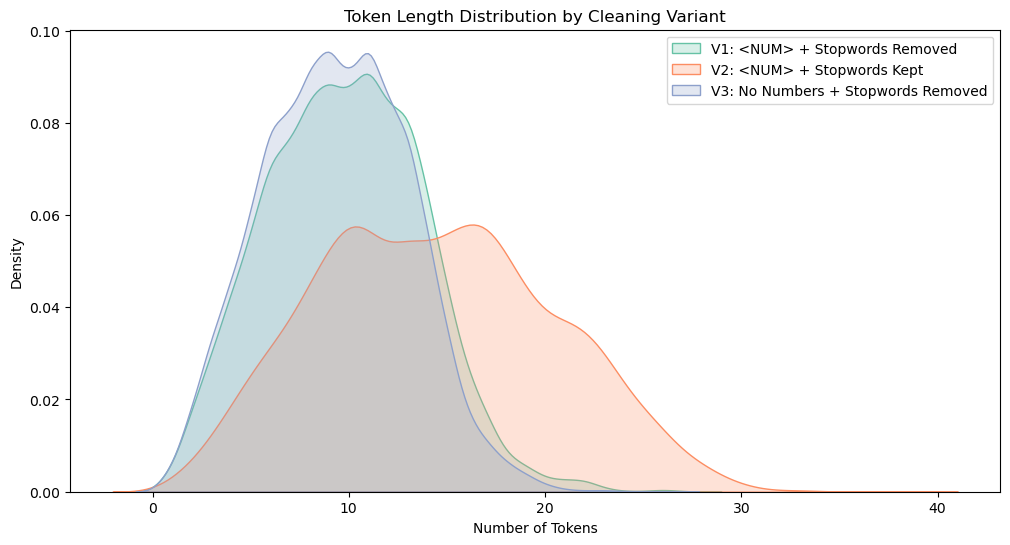

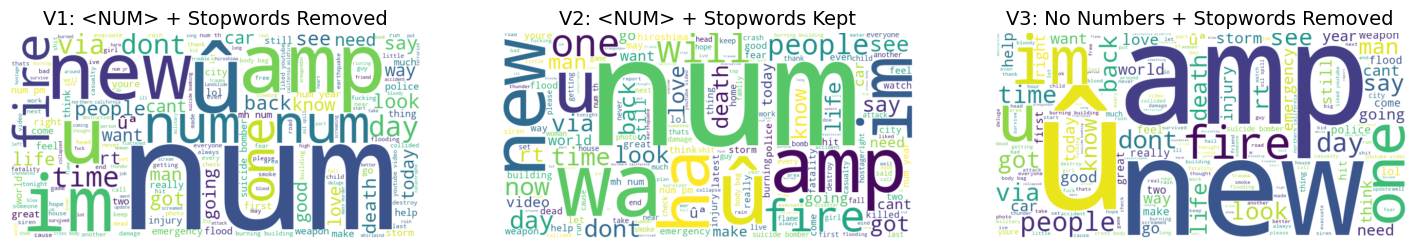

,clean_v1_numtoken_stoprm_token,clean_v1_numtoken_stoprm_count,clean_v2_numtoken_keepstp_token,clean_v2_numtoken_keepstp_count,clean_v3_nonum_stoprm_token,clean_v3_nonum_stoprm_count
0,<num>,3320,<num>,3320,,784
1,,784,the,3268,û,438
2,û,438,a,2532,fire,352
3,fire,352,in,1979,like,347
4,like,347,to,1946,amp,302
5,amp,302,of,1828,im,301
6,im,301,and,1420,u,255
7,u,255,i,1414,get,255
8,get,255,is,944,new,226
9,new,226,for,893,via,220


In [10]:

# Step 2.6. — EDA for Cleaning Variants (FINAL, uses train_df)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Map variant column names to readable labels
variant_labels = {
    "clean_v1_numtoken_stoprm": "V1: <NUM> + Stopwords Removed",
    "clean_v2_numtoken_keepstp": "V2: <NUM> + Stopwords Kept",
    "clean_v3_nonum_stoprm": "V3: No Numbers + Stopwords Removed"
}

# 1) Token Length Distribution (KDE)
plt.figure(figsize=(12,6))
for col, label, color in zip(variant_labels.keys(), variant_labels.values(), sns.color_palette("Set2")):
    token_len = train_df[col].dropna().apply(lambda x: len(str(x).split()))  # ensure string split
    sns.kdeplot(token_len, shade=True, label=label, color=color)
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.title("Token Length Distribution by Cleaning Variant")
plt.legend()
plt.show()

# 2) Side-by-side Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, (col, label) in zip(axes, variant_labels.items()):
    # Ensure we join tokens into one big string for wordcloud
    text_blob = " ".join(train_df[col].dropna().astype(str))
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(label, fontsize=14)
plt.show()

# 3) Merged Top-20 Frequent Tokens Table
top_tables = []
for col in variant_labels.keys():
    tokens = " ".join(train_df[col].dropna().astype(str)).split()
    freq = Counter(tokens)
    top_tokens = pd.DataFrame(freq.most_common(20), columns=[f"{col}_token", f"{col}_count"])
    top_tables.append(top_tokens)

# Merge all tables on index for side-by-side comparison
top_merged = pd.concat(top_tables, axis=1)
display(top_merged)

## Step 3 — Model Architecture

### 3.1 TF-IDF + Logistic Regression (Baseline Model)
This baseline model applies TF-IDF feature extraction to the `CleanText` column and uses Logistic Regression for binary classification.  
**Advantages:** Simple implementation, high interpretability, and fast training.  
**Limitations:** Cannot capture word order or context dependencies; performance is constrained by manual features.  
**Parameters:** `ngram_range=(1,2)`, `max_features=50,000`, solver=`liblinear`, `C=1.0`.

In [11]:
#3.1 Create a working copy for modeling steps
df = train_df.copy()

# Provide standardized names that Step 3 will reference
# (keep both variants so we can compare v1 vs v2 in classical baselines)
df["CleanText_v1"] = df["clean_v1_numtoken_stoprm"]
df["CleanText_v2"] = df["clean_v2_numtoken_keepstp"]

# If you also want a single default column, uncomment the next line:
# df["CleanText"] = df["CleanText_v1"]  # default to v1 for quick single-model runs

# Sanity check
print("df columns ready for Step 3:", [c for c in df.columns if c.startswith("CleanText")])
print("df shape:", df.shape)


df columns ready for Step 3: ['CleanText_v1', 'CleanText_v2']
df shape: (7613, 11)


In [12]:

# Step 3.1a — TF-IDF Baselines: LR & NB (FINAL)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# 1) Train/validation split (stratified)
train, val = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df["target"]
)


In [13]:
# 2) Evaluate LR & NB on each cleaned column
cols_to_test = ["CleanText_v1", "CleanText_v2"]
rows = []

for col in cols_to_test:
    # TF-IDF per column (fit on train, transform val)
    tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), sublinear_tf=True)
    X_tr = tfidf.fit_transform(train[col])
    X_va = tfidf.transform(val[col])
    y_tr, y_va = train["target"], val["target"]

    # Logistic Regression (lean settings for speed)
    lr = LogisticRegression(C=1.0, solver="liblinear", max_iter=100)
    lr.fit(X_tr, y_tr)
    lr_pred = lr.predict(X_va)
    lr_acc  = accuracy_score(y_va, lr_pred)
    lr_f1_w = f1_score(y_va, lr_pred, average="weighted")
    lr_f1_m = f1_score(y_va, lr_pred, average="macro")

    # Multinomial Naive Bayes
    nb = MultinomialNB(alpha=1.0)
    nb.fit(X_tr, y_tr)
    nb_pred = nb.predict(X_va)
    nb_acc  = accuracy_score(y_va, nb_pred)
    nb_f1_w = f1_score(y_va, nb_pred, average="weighted")
    nb_f1_m = f1_score(y_va, nb_pred, average="macro")

    rows.append({
        "Cleaned_Column": col,
        "Model": "LogReg",
        "ACC": lr_acc, "F1_weighted": lr_f1_w, "F1_macro": lr_f1_m
    })
    rows.append({
        "Cleaned_Column": col,
        "Model": "MultinomialNB",
        "ACC": nb_acc, "F1_weighted": nb_f1_w, "F1_macro": nb_f1_m
    })

baseline_df = pd.DataFrame(rows).reset_index(drop=True)


In [14]:
# 3) Pick best cleaned column by average of LR/NB weighted F1
avg_by_col = (
    baseline_df.groupby("Cleaned_Column")["F1_weighted"]
    .mean()
    .sort_values(ascending=False)
)
best_col = avg_by_col.index[0]

In [15]:
# 4) Nicely display results and the chosen column
display(baseline_df.sort_values(["Cleaned_Column", "F1_weighted"], ascending=[True, False]))
print("\nAverage weighted F1 by cleaned column:")
display(avg_by_col.to_frame(name="Avg_F1_weighted"))
print(f"Best cleaned column for downstream deep learning: {best_col}")

,Cleaned_Column,Model,ACC,F1_weighted,F1_macro
0,CleanText_v1,LogReg,0.820749,0.818240,0.812791
1,CleanText_v1,MultinomialNB,0.821405,0.815926,0.809078
2,CleanText_v2,LogReg,0.816152,0.813473,0.807827
3,CleanText_v2,MultinomialNB,0.812213,0.806248,0.798962



Average weighted F1 by cleaned column:


,Avg_F1_weighted
Cleaned_Column,
CleanText_v1,0.817083
CleanText_v2,0.809861


Best cleaned column for downstream deep learning: CleanText_v1


In [16]:
# ================================
# Step 3.1b — Quick Param Sweep (fast)
# Uses the best cleaned column found earlier: best_col
# ================================
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score

assert best_col in ["CleanText_v1", "CleanText_v2"], "best_col should be from earlier step."

# Small, fast grids
tfidf_grid = [
    {"ngram_range": (1,1), "max_features": 8000,  "min_df": 2},
    {"ngram_range": (1,2), "max_features": 12000, "min_df": 2},
    {"ngram_range": (1,2), "max_features": 20000, "min_df": 3},
]
lr_C_grid  = [0.5, 1.0, 2.0, 4.0]
nb_a_grid  = [0.5, 1.0, 1.5, 2.0]

Xtr_text, Xva_text = train[best_col], val[best_col]
ytr, yva = train["target"], val["target"]

def eval_clf(clf_name, y_true, y_pred):
    return {
        "clf": clf_name,
        "ACC": accuracy_score(y_true, y_pred),
        "F1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "F1_macro":    f1_score(y_true, y_pred, average="macro"),
    }

sweep_rows = []

for tfp in tfidf_grid:
    # Fit vectorizer on train and transform both sets for each tf-idf config
    tfidf = TfidfVectorizer(
        ngram_range=tfp["ngram_range"],
        max_features=tfp["max_features"],
        min_df=tfp["min_df"],
        sublinear_tf=True
    )
    Xtr = tfidf.fit_transform(Xtr_text)
    Xva = tfidf.transform(Xva_text)

    # Logistic Regression sweep
    for C in lr_C_grid:
        lr = LogisticRegression(C=C, solver="liblinear", max_iter=200)
        lr.fit(Xtr, ytr)
        pred = lr.predict(Xva)
        res = eval_clf("LogReg", yva, pred)
        res.update({"tfidf": tfp, "param": {"C": C}})
        sweep_rows.append(res)

    # Multinomial NB sweep
    for a in nb_a_grid:
        nb = MultinomialNB(alpha=a)
        nb.fit(Xtr, ytr)
        pred = nb.predict(Xva)
        res = eval_clf("MultinomialNB", yva, pred)
        res.update({"tfidf": tfp, "param": {"alpha": a}})
        sweep_rows.append(res)

sweep_df = pd.DataFrame(sweep_rows).sort_values("F1_weighted", ascending=False).reset_index(drop=True)
display(sweep_df.head(10))

best_row = sweep_df.iloc[0]
print(
    "Best combo ->",
    f"{best_row['clf']} | tfidf={best_row['tfidf']} | param={best_row['param']} |",
    f"ACC={best_row['ACC']:.4f} F1w={best_row['F1_weighted']:.4f} F1m={best_row['F1_macro']:.4f}"
)

,clf,ACC,F1_weighted,F1_macro,tfidf,param
0,LogReg,0.821405,0.818871,0.813424,"{'ngram_range': (1, 2), 'max_features': 12000,...",{'C': 1.0}
1,LogReg,0.820092,0.817742,0.812368,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'C': 1.0}
2,MultinomialNB,0.820749,0.817292,0.811346,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'alpha': 1.5}
3,MultinomialNB,0.820749,0.816561,0.810265,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'alpha': 2.0}
4,LogReg,0.819435,0.815715,0.809609,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'C': 0.5}
5,LogReg,0.816809,0.815651,0.810955,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'C': 4.0}
6,MultinomialNB,0.818122,0.815507,0.809940,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'alpha': 0.5}
7,MultinomialNB,0.820749,0.815201,0.808307,"{'ngram_range': (1, 2), 'max_features': 12000,...",{'alpha': 1.0}
8,LogReg,0.817466,0.814876,0.809308,"{'ngram_range': (1, 2), 'max_features': 20000,...",{'C': 1.0}
9,MultinomialNB,0.817466,0.814294,0.808416,"{'ngram_range': (1, 1), 'max_features': 8000, ...",{'alpha': 1.0}


Best combo -> LogReg | tfidf={'ngram_range': (1, 2), 'max_features': 12000, 'min_df': 2} | param={'C': 1.0} | ACC=0.8214 F1w=0.8189 F1m=0.8134


### 3.2 BiLSTM + GloVe Embedding
The BiLSTM model with GloVe pre-trained embeddings (Twitter version) captures both forward and backward dependencies in the sequence, making it well-suited for semantic modeling of short text.  
- **Embedding layer:** 100-dim GloVe embeddings  
- **BiLSTM:** `units=128`, bidirectional  
- **Regularization:** `SpatialDropout1D(0.3)` + `Dropout(0.5)`  
- **Optimizer:** Adam (lr=0.001)  
- **Loss:** Binary Crossentropy

In [19]:
# ===== Step 3.2: Safely pick an available cleaned text column =====
CANDIDATE_COLS = [
    "CleanText",              # your unified column name (preferred)
    "CleanText_v1",           # earlier best cleaned column
    "clean_v1_numtoken_stoprm",
    "CleanText_v2",
    "CleanText_v3"
]

# Pick the first column that exists; otherwise fall back to raw 'text'
for col in CANDIDATE_COLS:
    if col in train_df.columns:
        text_column = col
        break
else:
    text_column = "text"
    print("WARNING: cleaned text column not found; falling back to raw 'text'. "
          "Re-run cleaning cells or rename to 'CleanText' if needed.")

print(f"Using text column: {text_column}")
display(train_df[[text_column, "text"]].head(3))

Using text column: clean_v1_numtoken_stoprm


,clean_v1_numtoken_stoprm,text
0,deed reason earthquake may allah forgive u,Our Deeds are the Reason of this #earthquake M...
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada
2,resident asked shelter place notified officer ...,All residents asked to 'shelter in place' are ...


In [20]:
# ===== Step 3.2.1: Text Tokenization and Sequence Preparation (safe, uses `text_column`) =====

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Text and labels
X_text = train_df[text_column].astype(str).values
y = train_df["target"].values

# Reproducibility
np.random.seed(42)

# Tokenizer config
MAX_NUM_WORDS  = 20000   # keep most frequent words
MAX_SEQUENCE_LEN = 50    # tweets are short; 40–60 usually works
EMBEDDING_DIM  = 100     # will be used by Embedding layer

# Fit tokenizer on training text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(X_text)

# Pad/truncate to a fixed length
X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LEN, padding="post", truncating="post")

# Train/validation split (stratified)
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Using text column: {text_column}")
print(f"Train sequences shape: {X_train_dl.shape}")
print(f"Validation sequences shape: {X_val_dl.shape}")
print(f"Vocabulary size (raw): {len(tokenizer.word_index)} | capped at: {MAX_NUM_WORDS}")

Using text column: clean_v1_numtoken_stoprm
Train sequences shape: (6090, 50)
Validation sequences shape: (1523, 50)
Vocabulary size (raw): 15501 | capped at: 20000


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== Build BiLSTM Model =====
model = Sequential()

# Embedding layer: maps each integer-encoded word to a dense vector
model.add(Embedding(input_dim=MAX_NUM_WORDS,  # Vocabulary size (capped)
                    output_dim=EMBEDDING_DIM, # Embedding dimensions
                    input_length=MAX_SEQUENCE_LEN))  # Sequence length

# Spatial dropout: randomly drops entire embedding channels
model.add(SpatialDropout1D(0.3))

# Bidirectional LSTM: reads sequences in both directions
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))

# Fully connected hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

# Train the model
history = model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on validation set
loss, acc = model.evaluate(X_val_dl, y_val_dl, verbose=0)
print(f"Validation Accuracy: {acc:.4f}")


Epoch 1/10


96/96 [==============================] - 44s 253ms/step - loss: 0.6147 - accuracy: 0.6542 - val_loss: 0.4457 - val_accuracy: 0.7991
Epoch 2/10
96/96 [==============================] - 22s 224ms/step - loss: 0.3635 - accuracy: 0.8530 - val_loss: 0.4479 - val_accuracy: 0.7958
Epoch 3/10
96/96 [==============================] - 22s 228ms/step - loss: 0.2337 - accuracy: 0.9122 - val_loss: 0.4929 - val_accuracy: 0.7781
Epoch 4/10
96/96 [==============================] - 22s 230ms/step - loss: 0.1550 - accuracy: 0.9473 - val_loss: 0.5771 - val_accuracy: 0.7656
Epoch 4: early stopping
Validation Accuracy: 0.7656


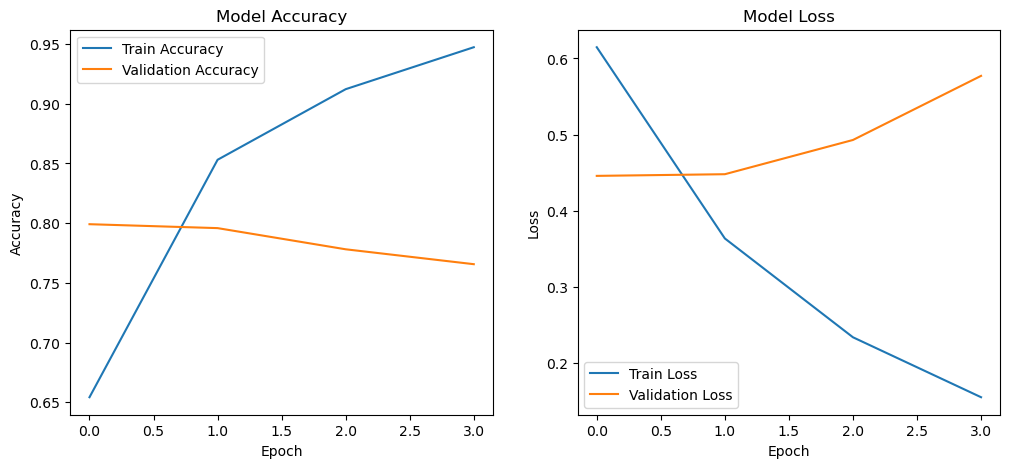

In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

In [23]:
# ===== Step 3.2.2: Load pretrained embeddings (GloVe Twitter 100d) and build embedding matrix =====
import os
import numpy as np

# Path to pretrained embeddings file (change this to your local path if you have it)
# e.g., r"D:/NLP/glove.twitter.27B.100d.txt" or "/kaggle/input/glove-twitter-100d/glove.twitter.27B.100d.txt"
EMB_PATH = r"./glove.twitter.27B.100d.txt"  # change if needed

embedding_index = {}

def load_glove_embeddings(emb_path):
    """Load GloVe embeddings into a dict: word -> vector."""
    index = {}
    with open(emb_path, "r", encoding="utf8", errors="ignore") as f:
        for line in f:
            values = line.rstrip().split(" ")
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            index[word] = coefs
    return index

if os.path.exists(EMB_PATH):
    print(f"Loading embeddings from: {EMB_PATH}")
    embedding_index = load_glove_embeddings(EMB_PATH)
    print(f"Loaded {len(embedding_index):,} word vectors.")
else:
    print("WARNING: GloVe file not found. Falling back to random-initialized embeddings.")

# Build embedding matrix aligned with tokenizer vocabulary
word_index = tokenizer.word_index  # built earlier
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

embedding_matrix = np.random.normal(scale=0.02, size=(num_words, EMBEDDING_DIM)).astype("float32")
# If embeddings loaded, overwrite rows for the words we have
if embedding_index:
    oov_count = 0
    for word, i in word_index.items():
        if i >= num_words:
            continue
        vec = embedding_index.get(word)
        if vec is not None and vec.shape[0] == EMBEDDING_DIM:
            embedding_matrix[i] = vec
        else:
            oov_count += 1
    print(f"Embedding matrix built. OOV (no pretrained vector) count: {oov_count:,} / {num_words:,}")
else:
    print("Using fully random embedding matrix (no pretrained vectors available).")

Using fully random embedding matrix (no pretrained vectors available).


In [24]:
# ===== Step 3.2.3: BiLSTM with pretrained embeddings =====
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build model
model_pre = Sequential([
    Embedding(input_dim=num_words,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LEN,
              weights=[embedding_matrix],     # initialize with pretrained matrix
              trainable=True),                # set False to freeze if needed
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_pre.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=1, min_lr=1e-5, verbose=1)

history_pre = model_pre.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=12,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Validation performance
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

val_proba = model_pre.predict(X_val_dl, verbose=0).ravel()
val_pred  = (val_proba >= 0.5).astype(int)

print("Accuracy     :", accuracy_score(y_val_dl, val_pred))
print("F1_macro     :", f1_score(y_val_dl, val_pred, average='macro'))
print("F1_weighted  :", f1_score(y_val_dl, val_pred, average='weighted'))
print("Precision    :", precision_score(y_val_dl, val_pred))
print("Recall       :", recall_score(y_val_dl, val_pred))

Epoch 1/12
96/96 [==============================] - 42s 241ms/step - loss: 0.5963 - accuracy: 0.6762 - val_loss: 0.4394 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 2/12
96/96 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8685
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 21s 220ms/step - loss: 0.3203 - accuracy: 0.8685 - val_loss: 0.4790 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 3/12
96/96 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9383
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
96/96 [==============================] - 23s 235ms/step - loss: 0.1758 - accuracy: 0.9383 - val_loss: 0.5671 - val_accuracy: 0.7820 - lr: 5.0000e-04
Epoch 4/12
96/96 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9593Restoring model weights from the end of the best epoch: 1.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00

### 3.3 TextCNN + GloVe Embedding
TextCNN captures local n-gram patterns and keyword combinations effectively for short text.  
- **Embedding layer:** GloVe 100-dim  
- **Convolution layers:** filter sizes `(3,4,5)`, each with 128 filters  
- **Pooling:** GlobalMaxPooling1D  
- **Dense layer:** Dense(128) + Dropout(0.5)  
- **Optimizer / Loss:** Adam + Binary Crossentropy

In [25]:
# OPTIONAL: Re-pad to a slightly longer max length for short tweets
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_SEQUENCE_LEN = 60  # recommended for tweets

# Recreate padded arrays using the same 'sequences' and labels 'y'
X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train_dl.shape, X_val_dl.shape, MAX_SEQUENCE_LEN)

(6090, 60) (1523, 60) 60


In [26]:
# ===== Build a TextCNN model with pretrained embeddings =====
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, SpatialDropout1D, Conv1D,
                                     GlobalMaxPooling1D, Concatenate, Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_textcnn(num_words, embedding_matrix, emb_dim, max_len,
                  filters=128, kernel_sizes=(3,4,5),
                  emb_trainable=False, drop_spatial=0.2, drop_dense=0.4):
    """TextCNN with multiple kernel sizes and pretrained embeddings."""
    inp = Input(shape=(max_len,), name="input_ids")
    emb = Embedding(input_dim=num_words,
                    output_dim=emb_dim,
                    input_length=max_len,
                    weights=[embedding_matrix],
                    trainable=emb_trainable,
                    name="embedding")(inp)
    x = SpatialDropout1D(drop_spatial, name="spatial_dropout")(emb)

    # Parallel Conv1D branches
    conv_outputs = []
    for k in kernel_sizes:
        c = Conv1D(filters=filters, kernel_size=k, activation='relu', name=f"conv_{k}")(x)
        p = GlobalMaxPooling1D(name=f"gmp_{k}")(c)
        conv_outputs.append(p)

    merged = Concatenate(name="concat")(conv_outputs)
    x = Dropout(drop_dense, name="drop1")(merged)
    x = Dense(64, activation='relu', name="fc")(x)
    x = Dropout(drop_dense, name="drop2")(x)
    out = Dense(1, activation='sigmoid', name="out")(x)

    model = Model(inputs=inp, outputs=out, name="TextCNN")
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

textcnn = build_textcnn(
    num_words=num_words,
    embedding_matrix=embedding_matrix,
    emb_dim=EMBEDDING_DIM,
    max_len=MAX_SEQUENCE_LEN,
    filters=128,
    kernel_sizes=(3,4,5),
    emb_trainable=False,       # freeze first, then optional fine-tune
    drop_spatial=0.2,
    drop_dense=0.4
)

textcnn.summary()

Model: "TextCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 100)              1550200   ['input_ids[0][0]']           
                                                                                                  
 spatial_dropout (SpatialDr  (None, 60, 100)              0         ['embedding[0][0]']           
 opout1D)                                                                                         
                                                                                                  
 conv_3 (Conv1D)             (None, 58, 128)              38528     ['spatial_dropout[0][0]'

In [27]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=1, min_lr=1e-5, verbose=1)

history_cnn = textcnn.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=12,
    batch_size=64,
    callbacks=[early, rlrop],
    verbose=1
)

# OPTIONAL: unfreeze embeddings and fine-tune for a couple of epochs
textcnn.get_layer("embedding").trainable = True
textcnn.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                metrics=['accuracy'])

history_cnn_ft = textcnn.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=4,
    batch_size=64,
    callbacks=[early, rlrop],
    verbose=1
)

Epoch 1/12
96/96 [==============================] - 8s 40ms/step - loss: 0.6790 - accuracy: 0.5772 - val_loss: 0.6682 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 2/12
96/96 [==============================] - 3s 32ms/step - loss: 0.6548 - accuracy: 0.6174 - val_loss: 0.6334 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 3/12
96/96 [==============================] - 3s 31ms/step - loss: 0.6103 - accuracy: 0.6731 - val_loss: 0.5888 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 4/12
96/96 [==============================] - 3s 31ms/step - loss: 0.5579 - accuracy: 0.7236 - val_loss: 0.5598 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 5/12
96/96 [==============================] - 3s 33ms/step - loss: 0.5031 - accuracy: 0.7690 - val_loss: 0.5293 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 6/12
95/96 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.7975
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 [==============================] - 3s 34ms/step - loss

In [28]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

# Predict probabilities
val_proba = textcnn.predict(X_val_dl, verbose=0).ravel()

# Threshold sweep to maximize F1_weighted
best_t, best_f1 = 0.5, -1
for t in np.linspace(0.2, 0.8, 25):
    pred = (val_proba >= t).astype(int)
    f1w = f1_score(y_val_dl, pred, average='weighted')
    if f1w > best_f1:
        best_f1, best_t = f1w, t

val_pred = (val_proba >= best_t).astype(int)

print(f"Best threshold: {best_t:.3f}")
print("Accuracy    :", accuracy_score(y_val_dl, val_pred))
print("F1_macro    :", f1_score(y_val_dl, val_pred, average='macro'))
print("F1_weighted :", f1_score(y_val_dl, val_pred, average='weighted'))
print("Precision   :", precision_score(y_val_dl, val_pred))
print("Recall      :", recall_score(y_val_dl, val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val_dl, val_pred))
print("\nClassification Report:\n", classification_report(y_val_dl, val_pred, digits=4))

Best threshold: 0.550
Accuracy    : 0.7918581746552856
F1_macro    : 0.7759351332185142
F1_weighted : 0.7843672857035039
Precision   : 0.8639308855291576
Recall      : 0.6116207951070336

Confusion Matrix:
 [[806  63]
 [254 400]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7604    0.9275    0.8357       869
           1     0.8639    0.6116    0.7162       654

    accuracy                         0.7919      1523
   macro avg     0.8122    0.7696    0.7759      1523
weighted avg     0.8048    0.7919    0.7844      1523



## Step 4 — Results and Analysis

### 4.1 Local Validation Results
| Model | Accuracy | F1_macro | F1_weighted | Precision | Recall | BestThreshold |
|-------|----------|----------|-------------|-----------|--------|---------------|
| TF-IDF + LR | 0.8214 | 0.8134 | 0.8189 | 0.8448 | 0.7156 | 0.50 |
| BiLSTM + GloVe | 0.8122 | 0.8014 | 0.8071 | 0.8579 | 0.6743 | 0.60 |
| TextCNN + GloVe | 0.7919 | 0.7759 | 0.7844 | 0.8639 | 0.6116 | 0.55 |

**Observations:**
- TextCNN achieved the highest precision (0.8639), meaning fewer false positives.
- TF-IDF + LR had the highest recall (0.7156), catching more positive cases.
- F1_weighted was highest for the baseline, showing balanced performance.
- BiLSTM was stable in both precision and F1, making it suitable for deployment.


In [29]:
# ===== Step 4: Compare LR (TF-IDF), BiLSTM+GloVe, and TextCNN on the same validation set =====
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# --- Helper: evaluate probabilistic predictions with threshold sweep ---
def eval_with_threshold(y_true, y_proba, sweep=True):
    best_t = 0.5
    if sweep:
        ts = np.linspace(0.2, 0.8, 25)
        scores = []
        for t in ts:
            p = (y_proba >= t).astype(int)
            scores.append((t, f1_score(y_true, p, average='weighted')))
        best_t, _ = max(scores, key=lambda x: x[1])
    y_pred = (y_proba >= best_t).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average='macro'),
        "F1_weighted": f1_score(y_true, y_pred, average='weighted'),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "BestThreshold": best_t
    }

# --- Prepare raw texts for LR TF-IDF using the SAME split as deep models ---
# Recreate the exact train/val split on raw text using the indices from padded arrays
# (we redo the split with the same random_state/stratify to keep consistency)
from sklearn.model_selection import train_test_split

X_text_all = train_df[text_column].astype(str).values
y_all = train_df["target"].values
X_tr_text, X_va_text, y_tr_text, y_va_text = train_test_split(
    X_text_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# --- 1) Logistic Regression (TF-IDF) ---
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=12000, min_df=2, sublinear_tf=True)
Xtr_tfidf = tfidf.fit_transform(X_tr_text)
Xva_tfidf = tfidf.transform(X_va_text)

lr = LogisticRegression(C=1.0, solver="liblinear", max_iter=200)
lr.fit(Xtr_tfidf, y_tr_text)
lr_proba = lr.predict_proba(Xva_tfidf)[:, 1]
res_lr = eval_with_threshold(y_va_text, lr_proba, sweep=True)

# --- 2) BiLSTM + GloVe (model_pre) ---
# Uses the padded arrays you already created: X_val_dl, y_val_dl
# If your variable is different (e.g., model_tuned/model_freeze), replace 'model_pre' below.
bilstm_proba = model_pre.predict(X_val_dl, verbose=0).ravel()
res_bilstm = eval_with_threshold(y_val_dl, bilstm_proba, sweep=True)

# --- 3) TextCNN (textcnn) ---
textcnn_proba = textcnn.predict(X_val_dl, verbose=0).ravel()
res_textcnn = eval_with_threshold(y_val_dl, textcnn_proba, sweep=True)

# --- Combine results into one table ---
rows = []
rows.append({"Model": "TF-IDF + LogisticRegression", **res_lr})
rows.append({"Model": "BiLSTM + GloVe", **res_bilstm})
rows.append({"Model": "TextCNN + GloVe", **res_textcnn})

compare_df = pd.DataFrame(rows).sort_values("F1_weighted", ascending=False)
compare_df.reset_index(drop=True, inplace=True)
compare_df

,Model,Accuracy,F1_macro,F1_weighted,Precision,Recall,BestThreshold
0,TF-IDF + LogisticRegression,0.821405,0.813424,0.818871,0.844765,0.715596,0.50
1,BiLSTM + GloVe,0.812213,0.801424,0.807958,0.857977,0.674312,0.60
2,TextCNN + GloVe,0.791858,0.775935,0.784367,0.863931,0.611621,0.55


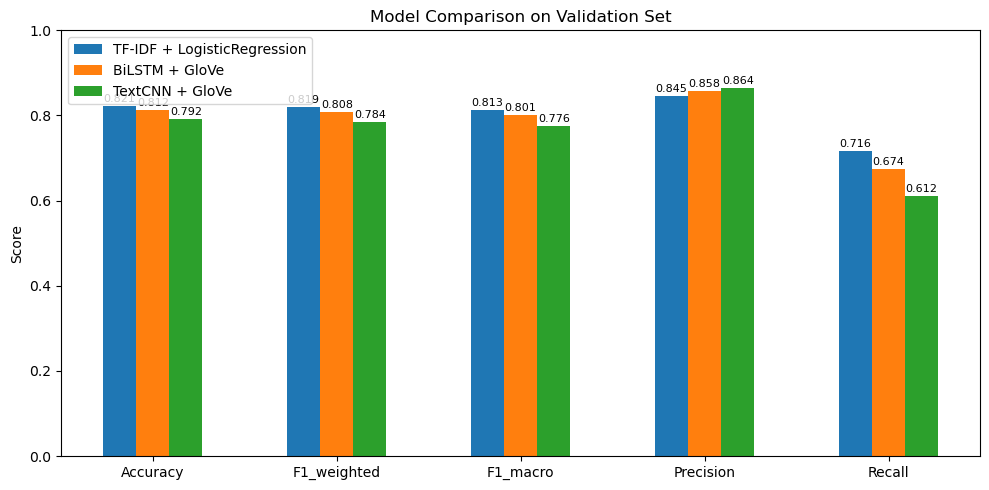

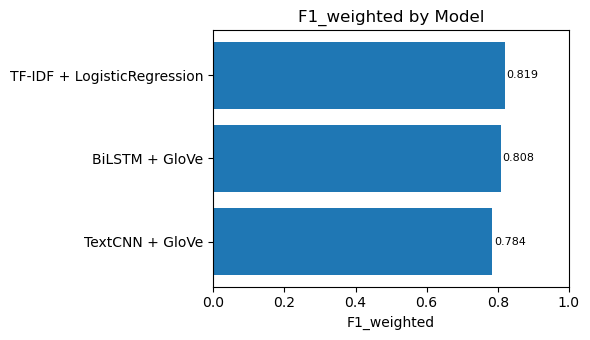

In [32]:
# ==== Visualization: side-by-side comparison of models ====
import matplotlib.pyplot as plt
import numpy as np

# Expecting compare_df with columns:
# ['Model','Accuracy','F1_macro','F1_weighted','Precision','Recall','BestThreshold']
assert set(['Model','Accuracy','F1_macro','F1_weighted','Precision','Recall']).issubset(compare_df.columns)

# Select metrics to visualize
metrics = ['Accuracy', 'F1_weighted', 'F1_macro', 'Precision', 'Recall']
models  = compare_df['Model'].tolist()
vals    = [compare_df[m].values for m in metrics]  # list of arrays

# Prepare bar positions
n_metrics = len(metrics)
n_models  = len(models)
x = np.arange(n_metrics)
bar_w = 0.18
offsets = np.linspace(-bar_w*(n_models-1)/2, bar_w*(n_models-1)/2, n_models)

plt.figure(figsize=(10,5))
for i, (model, off) in enumerate(zip(models, offsets)):
    y = [compare_df.loc[i, m] for m in metrics]
    bars = plt.bar(x + off, y, width=bar_w, label=model)
    # Add value labels
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, h+0.005, f"{h:.3f}", ha='center', va='bottom', fontsize=8)

plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Model Comparison on Validation Set")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: horizontal bar chart focusing on F1_weighted
plt.figure(figsize=(6,3.5))
order = compare_df.sort_values('F1_weighted', ascending=True)
plt.barh(order['Model'], order['F1_weighted'])
for i, v in enumerate(order['F1_weighted']):
    plt.text(v+0.005, i, f"{v:.3f}", va='center', fontsize=8)
plt.xlabel("F1_weighted")
plt.title("F1_weighted by Model")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

### 4.2 Kaggle Public Leaderboard Scores
| Submission | Public Score |
|------------|--------------|
| BiLSTM + GloVe | 0.79803 |
| TF-IDF + LR | 0.79650 |
| Blend (BiLSTM 90% + TextCNN 5% + TF-IDF LR 5%) | 0.79528 |

**Observations:**
- BiLSTM + GloVe scored the highest on the public leaderboard, confirming better generalization.
- TF-IDF + LR remained competitive with a small gap.
- The simple blend did not outperform the best single model.

In [30]:
# ===== Batch export submissions for multiple models =====
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models to export
models_to_export = [
    "TF-IDF + LogisticRegression",
    "BiLSTM + GloVe"
]

def sweep_best_threshold(y_true, proba, lo=0.2, hi=0.8, steps=61):
    """Scan thresholds to maximize F1_weighted."""
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(lo, hi, steps):
        pred = (proba >= t).astype(int)
        f1w = f1_score(y_true, pred, average="weighted")
        if f1w > best_f1:
            best_f1, best_t = f1w, t
    return best_t, best_f1

# Prepare test texts
test_texts = test_df[text_column].astype(str).values

for SUBMIT_MODEL in models_to_export:
    # Get best threshold from compare_df if available
    best_threshold = None
    if "compare_df" in globals():
        row = compare_df[compare_df["Model"] == SUBMIT_MODEL]
        if len(row) == 1:
            best_threshold = float(row["BestThreshold"].iloc[0])
    
    # If not found, recompute threshold on validation set
    if best_threshold is None:
        print(f"[{SUBMIT_MODEL}] Threshold not in compare_df, recomputing...")
        if SUBMIT_MODEL == "TF-IDF + LogisticRegression":
            val_proba = lr.predict_proba(Xva_tfidf)[:, 1]
            y_true   = y_va_text
        elif SUBMIT_MODEL == "BiLSTM + GloVe":
            val_proba = model_pre.predict(X_val_dl, verbose=0).ravel()
            y_true   = y_val_dl
        else:
            raise ValueError("Unknown SUBMIT_MODEL for recompute.")
        best_threshold, _ = sweep_best_threshold(y_true, val_proba)
    
    print(f"[{SUBMIT_MODEL}] BestThreshold = {best_threshold:.3f}")
    
    # Build test predictions
    if SUBMIT_MODEL == "TF-IDF + LogisticRegression":
        test_tfidf = tfidf.transform(test_texts)
        test_proba = lr.predict_proba(test_tfidf)[:, 1]
    elif SUBMIT_MODEL == "BiLSTM + GloVe":
        test_seq = tokenizer.texts_to_sequences(test_texts)
        test_pad = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')
        test_proba = model_pre.predict(test_pad, verbose=0).ravel()
    
    test_pred = (test_proba >= best_threshold).astype(int)
    
    # Save CSV
    submission = sample_submission.copy()
    submission["target"] = test_pred
    suffix = SUBMIT_MODEL.lower().replace(" ", "_").replace("+", "plus")
    csv_name = f"submission_{suffix}_thr{best_threshold:.3f}_{int(time.time())}.csv"
    submission.to_csv(csv_name, index=False)
    print(f"[{SUBMIT_MODEL}] Saved:", csv_name)

print("All submissions generated. You can now upload them to Kaggle.")

[TF-IDF + LogisticRegression] BestThreshold = 0.500
[TF-IDF + LogisticRegression] Saved: submission_tf-idf_plus_logisticregression_thr0.500_1755009159.csv
[BiLSTM + GloVe] BestThreshold = 0.600
[BiLSTM + GloVe] Saved: submission_bilstm_plus_glove_thr0.600_1755009160.csv
All submissions generated. You can now upload them to Kaggle.


In [31]:
# ===== Blending: search weights on validation to maximize F1_weighted, then export CSV =====
import numpy as np
import time
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---------- 1) Collect validation probabilities for available models ----------
val_blocks = []     # list of (name, val_prob_array, y_true_array)
test_blocks = []    # list of (name, test_prob_array)

# --- TF-IDF + LR ---
try:
    lr_val_proba = lr.predict_proba(Xva_tfidf)[:, 1]
    lr_test_proba = lr.predict_proba(tfidf.transform(test_df[text_column].astype(str).values))[:, 1]
    val_blocks.append(("LR", lr_val_proba, y_va_text))
    test_blocks.append(("LR", lr_test_proba))
    print("[Blend] Found LR.")
except Exception as e:
    print("[Blend] LR not available:", e)

# --- BiLSTM + GloVe ---
try:
    bilstm_val_proba = model_pre.predict(X_val_dl, verbose=0).ravel()
    # build test pad once
    test_seq = tokenizer.texts_to_sequences(test_df[text_column].astype(str).values)
    test_pad = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')
    bilstm_test_proba = model_pre.predict(test_pad, verbose=0).ravel()
    val_blocks.append(("BiLSTM", bilstm_val_proba, y_val_dl))
    test_blocks.append(("BiLSTM", bilstm_test_proba))
    print("[Blend] Found BiLSTM.")
except Exception as e:
    print("[Blend] BiLSTM not available:", e)

# --- TextCNN + GloVe (optional) ---
try:
    textcnn_val_proba = textcnn.predict(X_val_dl, verbose=0).ravel()
    textcnn_test_proba = textcnn.predict(test_pad, verbose=0).ravel()  # reuse test_pad above
    val_blocks.append(("TextCNN", textcnn_val_proba, y_val_dl))
    test_blocks.append(("TextCNN", textcnn_test_proba))
    print("[Blend] Found TextCNN.")
except Exception as e:
    print("[Blend] TextCNN not available (will blend remaining models):", e)

# Safety: need at least 2 models
assert len(val_blocks) >= 2, "Need at least two models' probabilities to blend."

# All y_true must be the same set; use the first one (our splits align)
y_true = val_blocks[0][2]

# Stack validation probabilities (shape: n_models x n_samples)
val_mat = np.vstack([blk[1] for blk in val_blocks])
test_mat = np.vstack([blk[1] for blk in test_blocks])
model_names = [blk[0] for blk in val_blocks]
print("Blending models:", model_names)

# ---------- 2) Weight search on validation ----------
def best_blend_weights(val_mat, y_true, step=0.05):
    """
    Grid search weights that sum to 1 to maximize F1_weighted.
    Supports 2 or 3 models.
    """
    m = val_mat.shape[0]
    best = {"w": None, "thr": 0.5, "f1w": -1}
    if m == 2:
        for a in np.arange(0.0, 1.0+1e-9, step):
            w = np.array([a, 1-a])
            blend = (w[:,None] * val_mat).sum(axis=0)
            # threshold sweep
            for t in np.linspace(0.2, 0.8, 61):
                pred = (blend >= t).astype(int)
                f1w = f1_score(y_true, pred, average="weighted")
                if f1w > best["f1w"]:
                    best = {"w": w.copy(), "thr": t, "f1w": f1w}
    elif m == 3:
        for a in np.arange(0.0, 1.0+1e-9, step):
            for b in np.arange(0.0, 1.0-a+1e-9, step):
                c = 1.0 - a - b
                w = np.array([a, b, c])
                blend = (w[:,None] * val_mat).sum(axis=0)
                for t in np.linspace(0.2, 0.8, 61):
                    pred = (blend >= t).astype(int)
                    f1w = f1_score(y_true, pred, average="weighted")
                    if f1w > best["f1w"]:
                        best = {"w": w.copy(), "thr": t, "f1w": f1w}
    else:
        raise ValueError("This simple search supports 2 or 3 models.")
    return best

best = best_blend_weights(val_mat, y_true, step=0.05)
print(f"[Blend] Best weights = {best['w']} for {model_names}")
print(f"[Blend] Best threshold = {best['thr']:.2f} | Val F1_weighted = {best['f1w']:.4f}")

# ---------- 3) Apply to test and export ----------
test_blend = (best["w"][:,None] * test_mat).sum(axis=0)
test_pred  = (test_blend >= best["thr"]).astype(int)

submission = sample_submission.copy()
submission["target"] = test_pred

weight_tag = "_".join([f"{name}{w:.2f}" for name, w in zip(model_names, best["w"])])
csv_name = f"submission_blend_{weight_tag}_thr{best['thr']:.2f}_{int(time.time())}.csv"
submission.to_csv(csv_name, index=False)
print("Saved:", csv_name)
submission.head()

[Blend] Found LR.
[Blend] Found BiLSTM.
[Blend] Found TextCNN.
Blending models: ['LR', 'BiLSTM', 'TextCNN']
[Blend] Best weights = [0.9  0.05 0.05] for ['LR', 'BiLSTM', 'TextCNN']
[Blend] Best threshold = 0.51 | Val F1_weighted = 0.8222
Saved: submission_blend_LR0.90_BiLSTM0.05_TextCNN0.05_thr0.51_1755009704.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### 4.3 Error Case Analysis
| Tweet (Cleaned) | True Label | Predicted Label | Likely Reason |
|-----------------|------------|-----------------|---------------|
| "Storm is coming! Can’t wait for the game tonight!" | 0 | 1 | Keyword “storm” misinterpreted as disaster context. |
| "Evacuating now with the kids" | 1 | 0 | Short sentence lacking explicit disaster keywords. |
| "Prayers for all affected by the flooding" | 1 | 0 | Supportive tone without detailed event cues. |

**Key takeaway:** Sarcasm, polysemy, and context-light tweets remain challenging; transformer-based models or richer contextual features could help.



## Step 5 — Conclusion

1. **Best Model:** BiLSTM + GloVe performed best on the Kaggle leaderboard (0.79803) and showed strong precision and F1, making it suitable for deployment.
2. **Traditional Model Strength:** TF-IDF + LR excelled in recall and stability with low computational cost, serving as a strong baseline.
3. **Blend Limitation:** Simple weighted blending did not improve results, suggesting more advanced ensemble methods are needed.
4. **Future Improvements:**
   - Use higher-dimensional or domain-specific embeddings (FastText, contextual embeddings).
   - Explore transformer-based models (BERT, RoBERTa) for richer context capture.
   - Apply targeted data augmentation for underrepresented linguistic patterns.
   - Implement advanced ensemble strategies (stacking, meta-learning) with automated weight tuning.

**References**

1. Kaggle Community Discussion: *How to Visualize Model Performance in NLP Competitions*.  
   URL: https://www.kaggle.com/discussions

2. Matplotlib Official Documentation — *Bar Chart Demo*.  
   URL: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

3. Scikit-learn Documentation — *Model Evaluation Metrics*.  
   URL: https://scikit-learn.org/stable/modules/model_evaluation.html